# Enabling Observability with OpenTelemetry

Atoti Python API features an observability plugin to integrate OpenTelemetry with Atoti for better monitoring and debugging capabilities. 

In this notebook, we’ll explore how to set up observability for Atoti Python API using OpenTelemetry.

<div style="text-align: center;" ><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try atoti"></a></div>

In [1]:
# !uv pip install 'atoti[observability]'

In [2]:
import atoti as tt
import zipfile
import wget
from IPython.display import clear_output, display

## Start the OTEL stack

To set up observability for Atoti using OpenTelemetry, we'll need a place to send our metrics, logs, and traces that can process and visualize our data.

The `docker-compose.yaml` located in `otel-stack` configures the containers for the following environment.

![otel-stack-diagram](otel-stack-diagram.png)

With the observability plugin, Atoti can use OpenTelemetry to output observability data, which is then handled by the corresponding services integrated with [Grafana](https://grafana.com/):

* **Traces:** Exported to Tempo (with OTLP).
* **Logs:** Exported to Loki (push to an endpoint).
* **Metrics:** Scraped from the OTEL collector endpoint via Prometheus every 15 seconds.

Navigate to `otel-stack` and execute the following command to setup and confirm the environment is running:

```bash
docker compose up -d
```

## Download data

To simulate more computation, we've prepared 2GB worth of trades and books data.

In [3]:
url = f"https://data.atoti.io/notebooks/observability-with-otel/data/data.zip"
filename = wget.download(url)

with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall()

100% [......................................................................] 843205063 / 843205063

## Configure the Atoti session

When using the observability plugin for Atoti Python API, we'll need to configure the underlying JVM to use OpenTelemetry. 

The following configurations are set as their defaults:

```java
"-Dspring.profiles.active=application-monitoring",
"-Dotel.java.global-autoconfigure.enabled=true",
"-Dotel.traces.exporter=otlp",
"-Dotel.metrics.exporter=otlp",
"-Dotel.logs.exporter=otlp",
"-Dotel.exporter.otlp.endpoint=http://localhost:4318",
"-Dotel.resource.attributes=service.name=atoti-spring-boot,service.version=1.0",
```

The following configurations are user specific:

```java
"-Djson.log.dir=logs",
"-Dotel.traces.sampler=always_on",
"-Dotel.metric.export.interval=1000",

```
    
We can also add in an OpenTelemetry java agent to report more metrics about the performance of the underlying JVM.

```java
"-javaagent:otel-stack/opentelemetry-javaagent.jar"
```


In [4]:
session = tt.Session.start(
    tt.SessionConfig(
        port=9090,
        java_options=[
            "-Dspring.profiles.active=application-monitoring",
            "-Dotel.java.global-autoconfigure.enabled=true",
            "-Dotel.traces.exporter=otlp",
            "-Dotel.metrics.exporter=otlp",
            "-Dotel.logs.exporter=otlp",
            "-Dotel.exporter.otlp.endpoint=http://localhost:4318",
            "-Dotel.resource.attributes=service.name=atoti-spring-boot,service.version=1.0",
            "-Djson.log.dir=logs",
            "-Dotel.traces.sampler=always_on",
            "-Dotel.metric.export.interval=1000",
            "-javaagent:otel-stack/opentelemetry-javaagent.jar",
        ]
    )
)

## Load data, join data, visualize data model

Trades Row Count: 383688
Books Row Count: 408


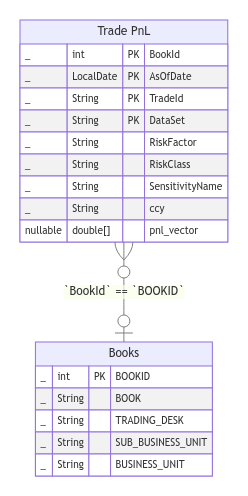

In [5]:
trades_tbl = session.read_csv(
    "data/trades/TradePnLs*.csv",
    table_name="Trade PnL",
    keys=["AsOfDate", "TradeId", "BookId", "DataSet"],
    array_separator=";",
)
books_tbl = session.read_csv(
    "data/books/books_books.csv", table_name="Books", keys=["BOOKID"]
)
trades_tbl.join(books_tbl, trades_tbl["BookId"] == books_tbl["BOOKID"])

print(f"Trades Row Count: {trades_tbl.row_count}")
print(f"Books Row Count: {books_tbl.row_count}")
session.tables.schema

In [6]:
cube = session.create_cube(trades_tbl)
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [7]:
m

{'pnl_vector.SUM': <atoti.measure.Measure object at 0x11852e790>, 'pnl_vector.MEAN': <atoti.measure.Measure object at 0x1191035d0>, 'contributors.COUNT': <atoti.measure.Measure object at 0x119103fd0>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x119103b50>}

### Computing VaR 95

Since we have a `pnl_vector.SUM` which is the sum of the profit and loss (PnL) value for each historical date, we define the formula of [value at risk (VaR)](https://www.investopedia.com/articles/04/092904.asp) at 95% confidence level as follows:

In [8]:
m["VaR95"] = tt.array.quantile(m["pnl_vector.SUM"], 1 - 0.95)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
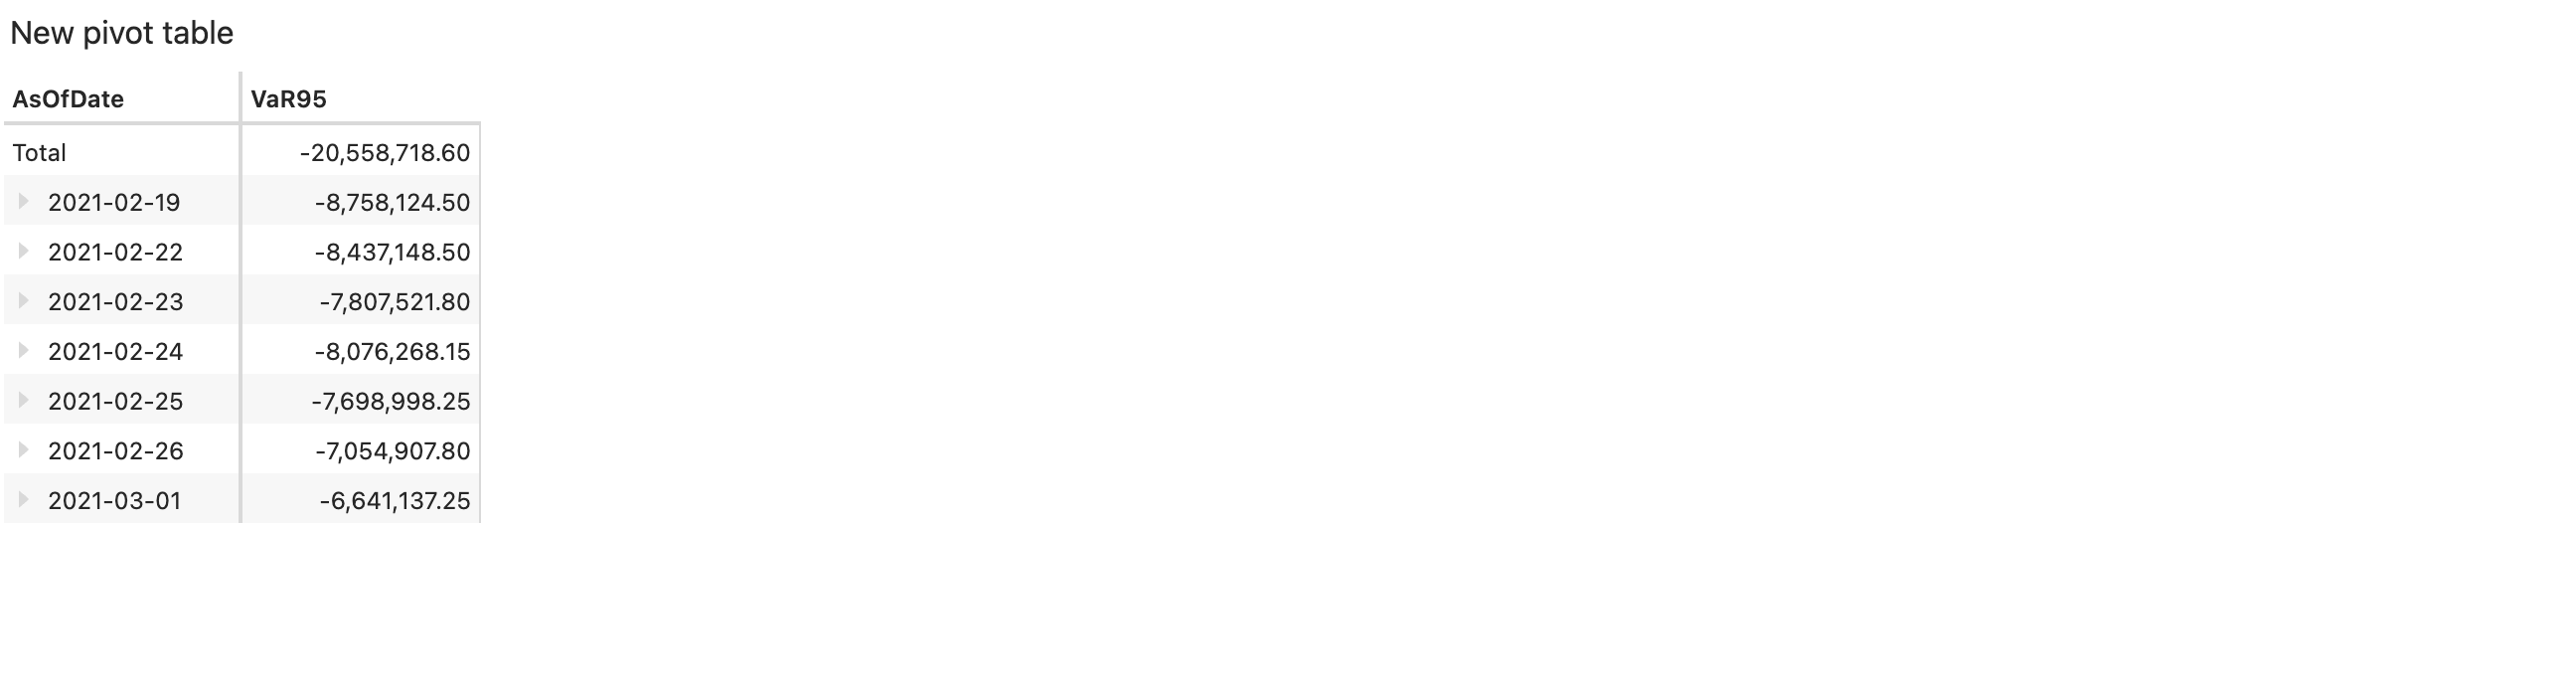

In [9]:
session.widget

## Monitoring Performance

By this point, Atoti will have already sent over observability data to the OpenTelemetry collector that we can then visualize in the Grafana using Loki, Tempo, and Prometheus.

### Metrics

Navigate to the Grafana UI located at [localhost:3000](http://localhost:3000) and click on the *Metrics* item in the left-hand pane to pull up the metric charts.

![metrics](metrics.png)

Similarly, we can also view the JVM metrics reported by the OpenTelemetry Java agent.

![java-metrics](java-metrics.png)

## Logs

![logs](logs.png)

## Traces

![logs-traceid](logs-traceid.png)

![traceid-spans](traceid-spans.png)

## Monitoring aggregate providers

Aggregate providers are used in Atoti to precompute and store aggregates for the finest granularity of aggregation possible for certain hierarchies. These intermediate aggregates are then stored in-memory and used to optimize queries. The result is a significant improvement in query performance but at the cost of a higher memory footprint.

Let's now use the observability plugin for Atoti Python API to monitor the creation and use of an aggregate provider.

In [10]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
    filter=(l["AsOfDate"] == "2021-02-26"),
)

CPU times: user 23.6 ms, sys: 6.78 ms, total: 30.4 ms
Wall time: 153 ms


VaR95
BUSINESS_UNIT   SUB_BUSINESS_UNIT       TRADING_DESK               
Equity          Foreign Equity          Hermes        -3,757,225.95
Forex           Developed Market        Hades         -3,764,391.95
Rates & Credits Domestic Rates & Credit Hermes        -4,444,005.95
                                        Keres         -3,414,020.40

In [11]:
cube.aggregate_providers.update(
    {
        "PnL provider": tt.AggregateProvider(
            key="leaf",
            levels=[
                l["AsOfDate"],
                l["BUSINESS_UNIT"],
                l["SUB_BUSINESS_UNIT"],
                l["TRADING_DESK"],
            ],
            measures=[m["pnl_vector.SUM"]],
            filter=(l["AsOfDate"] == "2021-02-26"),
        )
    }
)

In [12]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"], l["ccy"]],
    filter=(l["AsOfDate"] == "2021-02-26"),
)

CPU times: user 9.91 ms, sys: 2.45 ms, total: 12.4 ms
Wall time: 76.4 ms


VaR95
BUSINESS_UNIT   SUB_BUSINESS_UNIT       TRADING_DESK ccy               
Equity          Foreign Equity          Hermes       EUR  -3,757,225.95
Forex           Developed Market        Hades        EUR  -3,764,391.95
Rates & Credits Domestic Rates & Credit Hermes       EUR  -4,444,005.95
                                        Keres        EUR  -3,414,020.40